In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist import floating_axes
from mpl_toolkits.axisartist import grid_finder

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from mask import polygon_to_mask
from namelist import *

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
simvar = 'O3'
obsvar = 'O3'

In [3]:
df = pd.DataFrame(
    index=pd.date_range(start='2023-07-01T00', end='2023-07-31T23', freq='H')
)

## 获取模拟与观测数据

In [4]:
years = [2019,2021,2022]

for year in years:
    ds = xr.open_dataset(datadir + f'processed/Jul_{year}/Jul_{year}_chem.nc')
    data_sim = ds[simvar][:,0,:,:]

    shp = gpd.read_file(shp_files['PRD_merge_adm'])
    lon = data_sim.longitude
    lat = data_sim.latitude
    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))
    masked_sim  = data_sim.where(mask_da)
    sim    = masked_sim.mean(dim=('x','y'),skipna=True)

    obspath = get_obspath(month='Jul')
    dfobs = pd.read_excel(obspath + f'site_{obsvar}_{year}.xlsx',index_col=0)
    obs = dfobs.mean(axis=1,skipna=True)
    obs.interpolate(method='linear',inplace=True)
    
    df[f'sim_{year}']=sim
    df[f'obs_{year}']=obs.values
    print(f'Complete {year}')

Complete 2019
Complete 2021
Complete 2022


In [5]:
df

,sim_2019,obs_2019,sim_2021,obs_2021,sim_2022,obs_2022
2023-07-01 00:00:00,69.926414,30.333333,52.710552,37.525000,38.281609,19.871795
2023-07-01 01:00:00,66.185638,29.555556,50.979946,37.000000,37.330921,19.948052
2023-07-01 02:00:00,63.311085,26.611111,49.147179,36.412500,38.142834,21.666667
2023-07-01 03:00:00,60.357597,22.962963,46.836723,35.875000,39.621162,22.662162
2023-07-01 04:00:00,57.655926,20.358491,44.864399,35.487179,40.639435,22.605263
...,...,...,...,...,...,...
2023-07-31 19:00:00,55.146336,21.090909,101.495392,71.202532,139.062119,184.307692
2023-07-31 20:00:00,52.783115,20.821429,90.222824,56.612500,122.131424,151.641026
2023-07-31 21:00:00,51.580044,20.821429,80.706001,44.139241,108.405258,122.974026
2023-07-31 22:00:00,51.584473,22.357143,72.802841,38.734177,95.622078,101.934211


## 定义绘图函数

In [6]:
def set_tayloraxes(fig, location):
    trans = PolarAxes.PolarTransform()
    r1_locs = np.hstack((np.arange(1,10)/10.0,[0.95,0.99]))
    t1_locs = np.arccos(r1_locs)        
    gl1 = grid_finder.FixedLocator(t1_locs)    
    tf1 = grid_finder.DictFormatter(dict(zip(t1_locs, map(str,r1_locs))))
    r2_locs = np.arange(0,2.5,0.25)
    r2_labels = ['0 ', '0.25 ', '0.50 ', '0.75 ', 'REF ', '1.25 ', '1.50 ', '1.75 ','2.0','2.25']
    gl2 = grid_finder.FixedLocator(r2_locs)
    tf2 = grid_finder.DictFormatter(dict(zip(r2_locs, map(str,r2_labels))))
    ghelper = floating_axes.GridHelperCurveLinear(trans,extremes=(0,np.pi/2,0,2.25),
                                                  grid_locator1=gl1,tick_formatter1=tf1,
                                                  grid_locator2=gl2,tick_formatter2=tf2)
    ax = floating_axes.FloatingSubplot(fig, location, grid_helper=ghelper)
    fig.add_subplot(ax)

    ax.axis["top"].set_axis_direction("bottom")  
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")
    ax.axis["top"].label.set_fontsize(14)
    ax.axis["left"].set_axis_direction("bottom") 
    ax.axis["left"].label.set_text("Standard deviation(Normalized)")
    ax.axis["left"].label.set_fontsize(14)
    ax.axis["right"].set_axis_direction("top")   
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].major_ticklabels.set_axis_direction("left")
    ax.axis["bottom"].set_visible(False)         
    ax.grid(True)
    polar_ax = ax.get_aux_axes(trans)   

    rs,ts = np.meshgrid(np.linspace(0,2.25,100),
                            np.linspace(0,np.pi/2,100))
    rms = np.sqrt(1 + rs**2 - 2*rs*np.cos(ts))
    CS = polar_ax.contour(ts, rs,rms,colors='gray',linestyles='--')
    plt.clabel(CS, inline=1, fontsize=10)
    t = np.linspace(0,np.pi/2)
    r = np.zeros_like(t) + 1
    polar_ax.plot(t,r,'r--')
    polar_ax.text(np.pi/2+0.045,1.02, " 1.00", size=10.3,ha="right", va="top",
                  bbox=dict(boxstyle="square",ec='w',fc='w'))

    return polar_ax

def plot_taylor(axes, refsample, sample, *args, **kwargs):
    std = np.std(refsample)/np.std(sample)
    corr = np.corrcoef(refsample, sample) 
    theta = np.arccos(corr[0,1])
    t,r = theta,std
    d = axes.plot(t,r, *args, **kwargs) 
    return d


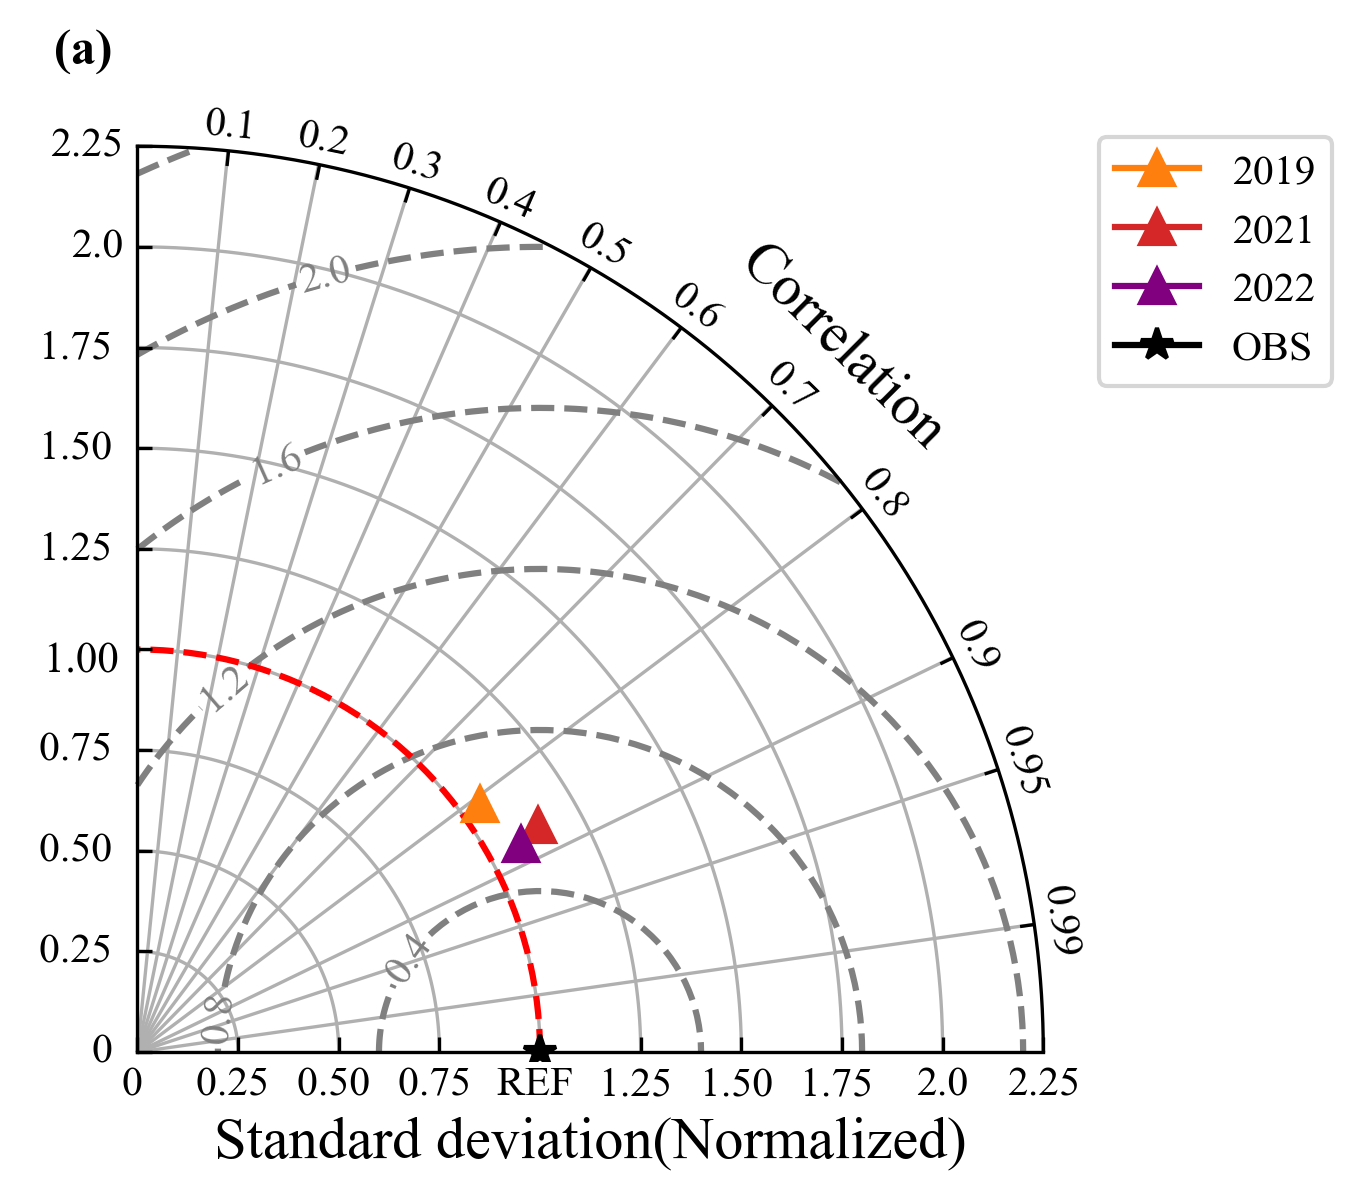

In [8]:
markersyle_low = {
    'marker':'o',
    'markersize':8,
}
markersyle_high = {
    'marker':'^',
    'markersize':8,
}

fig = plt.figure(figsize=(4,4),dpi=300)
ax = set_tayloraxes(fig, 111)

d4 = plot_taylor(ax,df['obs_2019'],df['sim_2019'],label='2019',color='tab:orange', **markersyle_high)
d5 = plot_taylor(ax,df['obs_2021'],df['sim_2021'],label='2021',color='tab:red', **markersyle_high)
d6 = plot_taylor(ax,df['obs_2022'],df['sim_2022'],label='2022',color='purple', **markersyle_high)

d7 = plot_taylor(ax,df['obs_2019'],df['obs_2019'],label='OBS',color='k',marker='*',markersize=8)

ax.text(-0.08, 1.08, '(a)', transform=ax.transAxes, fontsize=12, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)

plt.savefig(f'D:/Academic/Project/GRAD/Seasonally/figures/泰勒图/{simvar}.png',
            dpi=300, bbox_inches='tight')

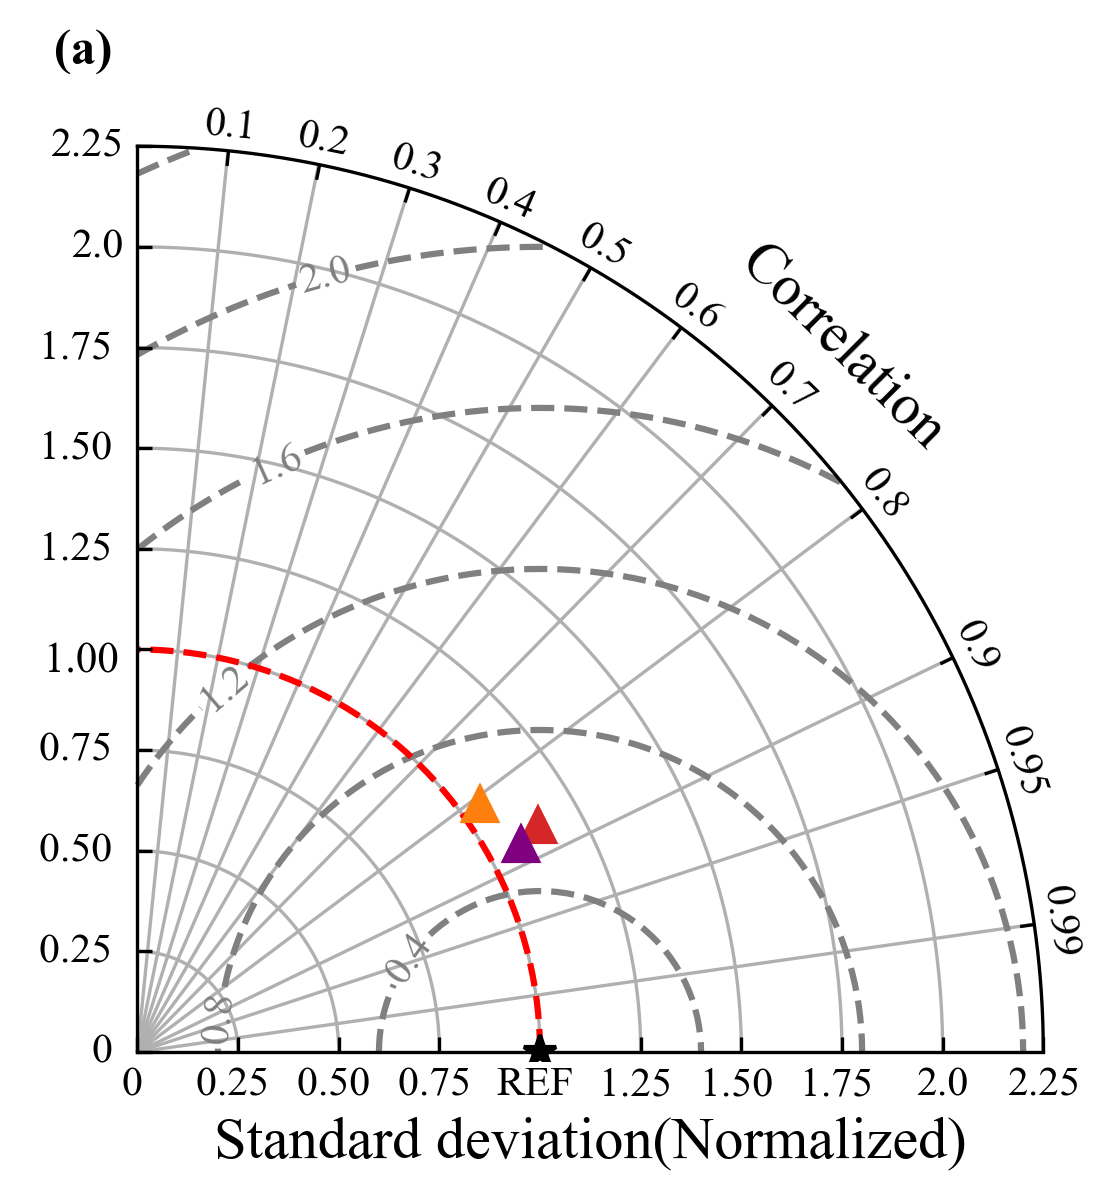

In [9]:
markersyle_low = {
    'marker':'o',
    'markersize':8,
}
markersyle_high = {
    'marker':'^',
    'markersize':8,
}

fig = plt.figure(figsize=(4,4),dpi=300)
ax = set_tayloraxes(fig, 111)

d4 = plot_taylor(ax,df['obs_2019'],df['sim_2019'],label='2019',color='tab:orange', **markersyle_high)
d5 = plot_taylor(ax,df['obs_2021'],df['sim_2021'],label='2021',color='tab:red', **markersyle_high)
d6 = plot_taylor(ax,df['obs_2022'],df['sim_2022'],label='2022',color='purple', **markersyle_high)

d7 = plot_taylor(ax,df['obs_2019'],df['obs_2019'],label='OBS',color='k',marker='*',markersize=8)

ax.text(-0.08, 1.08, '(a)', transform=ax.transAxes, fontsize=12, fontweight='bold')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)

plt.savefig(f'D:/Academic/Project/GRAD/Seasonally/figures/泰勒图/{simvar}_nolegend.png',
            dpi=300, bbox_inches='tight')